In [1]:
import json

In [2]:
path = 'rated_datasets/Rotten_Tomato_Merlin_1519148528.2417703.json'

In [3]:
data =json.load(open(path, "r", encoding="utf8"))
data

{'dataset': 'Rotten Tomato',
 'edge_type_selection': [['PRODUCED', True],
  ['DIRECTED', True],
  ['WROTE', True],
  ['ACTED_IN', True]],
 'meta_paths': [{'time_to_rate': 0.024361},
  {'id': 1,
   'metapath': ['Person',
    'PRODUCED',
    'Movie',
    'DIRECTED',
    'Person',
    'PRODUCED',
    'Movie',
    'ACTED_IN',
    'Person'],
   'rating': '0.1'},
  {'id': 2,
   'metapath': ['Person', 'PRODUCED', 'Movie', 'ACTED_IN', 'Person'],
   'rating': '0.25'},
  {'id': 3,
   'metapath': ['Person',
    'DIRECTED',
    'Movie',
    'WROTE',
    'Person',
    'PRODUCED',
    'Movie',
    'ACTED_IN',
    'Person'],
   'rating': '0.15'},
  {'id': 4,
   'metapath': ['Person',
    'DIRECTED',
    'Movie',
    'PRODUCED',
    'Person',
    'WROTE',
    'Movie',
    'ACTED_IN',
    'Person'],
   'rating': '0.15'},
  {'id': 5,
   'metapath': ['Person',
    'PRODUCED',
    'Movie',
    'ACTED_IN',
    'Person',
    'ACTED_IN',
    'Movie',
    'ACTED_IN',
    'Person'],
   'rating': '0.2'},
  {'ti

In [4]:
data["meta_paths"]

[{'time_to_rate': 0.024361},
 {'id': 1,
  'metapath': ['Person',
   'PRODUCED',
   'Movie',
   'DIRECTED',
   'Person',
   'PRODUCED',
   'Movie',
   'ACTED_IN',
   'Person'],
  'rating': '0.1'},
 {'id': 2,
  'metapath': ['Person', 'PRODUCED', 'Movie', 'ACTED_IN', 'Person'],
  'rating': '0.25'},
 {'id': 3,
  'metapath': ['Person',
   'DIRECTED',
   'Movie',
   'WROTE',
   'Person',
   'PRODUCED',
   'Movie',
   'ACTED_IN',
   'Person'],
  'rating': '0.15'},
 {'id': 4,
  'metapath': ['Person',
   'DIRECTED',
   'Movie',
   'PRODUCED',
   'Person',
   'WROTE',
   'Movie',
   'ACTED_IN',
   'Person'],
  'rating': '0.15'},
 {'id': 5,
  'metapath': ['Person',
   'PRODUCED',
   'Movie',
   'ACTED_IN',
   'Person',
   'ACTED_IN',
   'Movie',
   'ACTED_IN',
   'Person'],
  'rating': '0.2'},
 {'time_to_rate': 150.249221},
 {'id': 6,
  'metapath': ['Person',
   'PRODUCED',
   'Movie',
   'WROTE',
   'Person',
   'DIRECTED',
   'Movie',
   'ACTED_IN',
   'Person'],
  'rating': '0.16'},
 {'id': 7,

In [5]:
data["meta_paths"][1]

{'id': 1,
 'metapath': ['Person',
  'PRODUCED',
  'Movie',
  'DIRECTED',
  'Person',
  'PRODUCED',
  'Movie',
  'ACTED_IN',
  'Person'],
 'rating': '0.1'}

In [6]:
i = 0
first = True
for probably_path in data["meta_paths"]:
    # Ignore first time_to_rate
    if first:
        first = False
        continue
    i += 1
    if i == 6:
        # Ignore time_to_rate
        i = 0
    else:
        if 'time_to_rate' not in probably_path.keys():
            print(probably_path)

{'id': 1, 'metapath': ['Person', 'PRODUCED', 'Movie', 'DIRECTED', 'Person', 'PRODUCED', 'Movie', 'ACTED_IN', 'Person'], 'rating': '0.1'}
{'id': 2, 'metapath': ['Person', 'PRODUCED', 'Movie', 'ACTED_IN', 'Person'], 'rating': '0.25'}
{'id': 3, 'metapath': ['Person', 'DIRECTED', 'Movie', 'WROTE', 'Person', 'PRODUCED', 'Movie', 'ACTED_IN', 'Person'], 'rating': '0.15'}
{'id': 4, 'metapath': ['Person', 'DIRECTED', 'Movie', 'PRODUCED', 'Person', 'WROTE', 'Movie', 'ACTED_IN', 'Person'], 'rating': '0.15'}
{'id': 5, 'metapath': ['Person', 'PRODUCED', 'Movie', 'ACTED_IN', 'Person', 'ACTED_IN', 'Movie', 'ACTED_IN', 'Person'], 'rating': '0.2'}
{'id': 6, 'metapath': ['Person', 'PRODUCED', 'Movie', 'WROTE', 'Person', 'DIRECTED', 'Movie', 'ACTED_IN', 'Person'], 'rating': '0.16'}
{'id': 7, 'metapath': ['Person', 'DIRECTED', 'Movie', 'ACTED_IN', 'Person', 'ACTED_IN', 'Movie', 'ACTED_IN', 'Person'], 'rating': '0.26'}
{'id': 8, 'metapath': ['Person', 'ACTED_IN', 'Movie', 'PRODUCED', 'Person', 'WROTE', 'Mo

In [7]:
i = 0
first = True
batches = []
batch = []
for probably_path in data["meta_paths"]:
    # Ignore first time_to_rate
    if first:
        first = False
        continue
    i += 1
    if i == 6:
        # Ignore time_to_rate
        i = 0
        batches.append(batch)
        batch = []
    else:
        if 'time_to_rate' not in probably_path.keys():
            batch.append(probably_path)

In [8]:
batches

[[{'id': 1,
   'metapath': ['Person',
    'PRODUCED',
    'Movie',
    'DIRECTED',
    'Person',
    'PRODUCED',
    'Movie',
    'ACTED_IN',
    'Person'],
   'rating': '0.1'},
  {'id': 2,
   'metapath': ['Person', 'PRODUCED', 'Movie', 'ACTED_IN', 'Person'],
   'rating': '0.25'},
  {'id': 3,
   'metapath': ['Person',
    'DIRECTED',
    'Movie',
    'WROTE',
    'Person',
    'PRODUCED',
    'Movie',
    'ACTED_IN',
    'Person'],
   'rating': '0.15'},
  {'id': 4,
   'metapath': ['Person',
    'DIRECTED',
    'Movie',
    'PRODUCED',
    'Person',
    'WROTE',
    'Movie',
    'ACTED_IN',
    'Person'],
   'rating': '0.15'},
  {'id': 5,
   'metapath': ['Person',
    'PRODUCED',
    'Movie',
    'ACTED_IN',
    'Person',
    'ACTED_IN',
    'Movie',
    'ACTED_IN',
    'Person'],
   'rating': '0.2'}],
 [{'id': 6,
   'metapath': ['Person',
    'PRODUCED',
    'Movie',
    'WROTE',
    'Person',
    'DIRECTED',
    'Movie',
    'ACTED_IN',
    'Person'],
   'rating': '0.16'},
  {'id': 7,

In [10]:
from util.datastructures import MetaPathRatingGraph, MetaPath
graph = MetaPathRatingGraph()

for batch in batches:
    #ordered = sorted(batch, key=lambda x: float(x['rating']))
    for metapath in batch:
        for another_metapath in batch:
            if metapath is another_metapath:
                continue
            if float(metapath['rating']) <= float(another_metapath['rating']):
                graph.add_user_rating(MetaPath.from_list(another_metapath['metapath']), MetaPath.from_list(metapath['metapath']), 
                                      distance=float(another_metapath['rating']) - float(metapath['rating']))

In [37]:
import domain_scoring.domain_scoring as domain_scoring
domain_score = domain_scoring.DomainScoring()
domain_score.fit(graph, test_size=0.3)

NotFittedError: This DecisionTreeClassifier instance is not fitted yet. Call 'fit' with appropriate arguments before using this method.

Feature ranking:
1. feature 8 (0.252934)
2. feature 0 (0.241715)
3. feature 6 (0.141816)
4. feature 1 (0.069899)
5. feature 9 (0.061769)
6. feature 2 (0.059382)
7. feature 4 (0.059261)
8. feature 10 (0.036441)
9. feature 3 (0.034537)
10. feature 7 (0.021453)
11. feature 5 (0.014518)
12. feature 11 (0.006274)


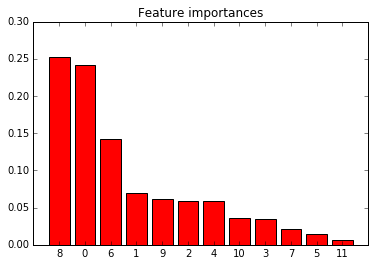

In [35]:
import numpy as np
import matplotlib.pyplot as plt

importances = domain_score.classifier.feature_importances_
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(len(domain_score.classifier.feature_importances_)):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(len(domain_score.classifier.feature_importances_)), importances[indices],
       color="r", align="center")
plt.xticks(range(len(domain_score.classifier.feature_importances_)), indices)
plt.xlim([-1, len(domain_score.classifier.feature_importances_)])
plt.show()